In [45]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.patches as mpatches
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import average_precision_score, precision_recall_curve

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import collections

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt



from scipy import misc
import pymysql as mdb

%matplotlib notebook

# Reading Data

In [46]:
songs_df = pd.read_csv('spotify_data.csv')

In [47]:
songs_df.head(5)

,acousticness,danceability,energy,ind,instrumentalness,key,label,liveness,loudness,mode,song_id,song_name,speechiness,tempo,valence
0,0.1560,0.793,0.714,222,0.000000,7,1,0.1360,-7.562,1,02Ygu8lo3qSknRpcBnspso,Just Friends,0.1930,100.036,0.794
1,0.2720,0.783,0.430,47,0.000002,11,0,0.2540,-9.783,1,03ZFDJXHFi8dDSf2dmBNoR,Footprint,0.2830,82.066,0.192
2,0.7550,0.815,0.308,217,0.001040,5,1,0.1080,-10.956,1,04Fd2hmbDWV4Lc7OLarvBa,The Best Of Myself,0.0463,79.492,0.572
3,0.1820,0.654,0.739,53,0.000000,9,0,0.0646,-5.093,0,04wkQ3rrZMebfFN3t2DS7w,Light of You,0.0826,124.051,0.522
4,0.0073,0.826,0.790,212,0.000010,10,1,0.1220,-4.341,1,07s9NNOT0sZQp7TyolLLgu,Own It (feat. Ed Sheeran & Burna Boy),0.1260,104.032,0.377


In [48]:
#song_names = list(songs_df["song_name"])
#songs_df = songs_df.drop(columns=['ind','song_name', 'song_id'])

In [49]:
songs_df.describe()
#remove ind, song_name, song_id

,acousticness,danceability,energy,ind,instrumentalness,key,label,liveness,loudness,mode,speechiness,tempo,valence
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.197484,0.635858,0.659269,92.597360,0.027088,5.356436,0.739274,0.156967,-5.940611,0.633663,0.095565,118.673106,0.464918
std,0.227721,0.147750,0.181107,65.221448,0.136970,3.709441,0.439757,0.114932,2.278152,0.482600,0.093680,28.104794,0.223869
min,0.000007,0.221000,0.057500,0.000000,0.000000,0.000000,0.000000,0.024300,-16.996000,0.000000,0.023200,62.633000,0.037100
25%,0.032600,0.532000,0.536000,37.500000,0.000000,1.000000,0.000000,0.090400,-6.938000,0.000000,0.041150,98.048000,0.290500
50%,0.106000,0.655000,0.671000,75.000000,0.000000,6.000000,1.000000,0.114000,-5.659000,1.000000,0.057400,115.555000,0.464000
75%,0.279500,0.744000,0.795000,147.500000,0.000017,8.000000,1.000000,0.179500,-4.589500,1.000000,0.106000,135.533000,0.621000
max,0.950000,0.965000,0.991000,223.000000,0.922000,11.000000,1.000000,0.760000,-1.580000,1.000000,0.503000,205.272000,0.969000


In [50]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
acousticness        303 non-null float64
danceability        303 non-null float64
energy              303 non-null float64
ind                 303 non-null int64
instrumentalness    303 non-null float64
key                 303 non-null int64
label               303 non-null int64
liveness            303 non-null float64
loudness            303 non-null float64
mode                303 non-null int64
song_id             303 non-null object
song_name           303 non-null object
speechiness         303 non-null float64
tempo               303 non-null float64
valence             303 non-null float64
dtypes: float64(9), int64(4), object(2)
memory usage: 35.6+ KB


<IPython.core.display.Javascript object>


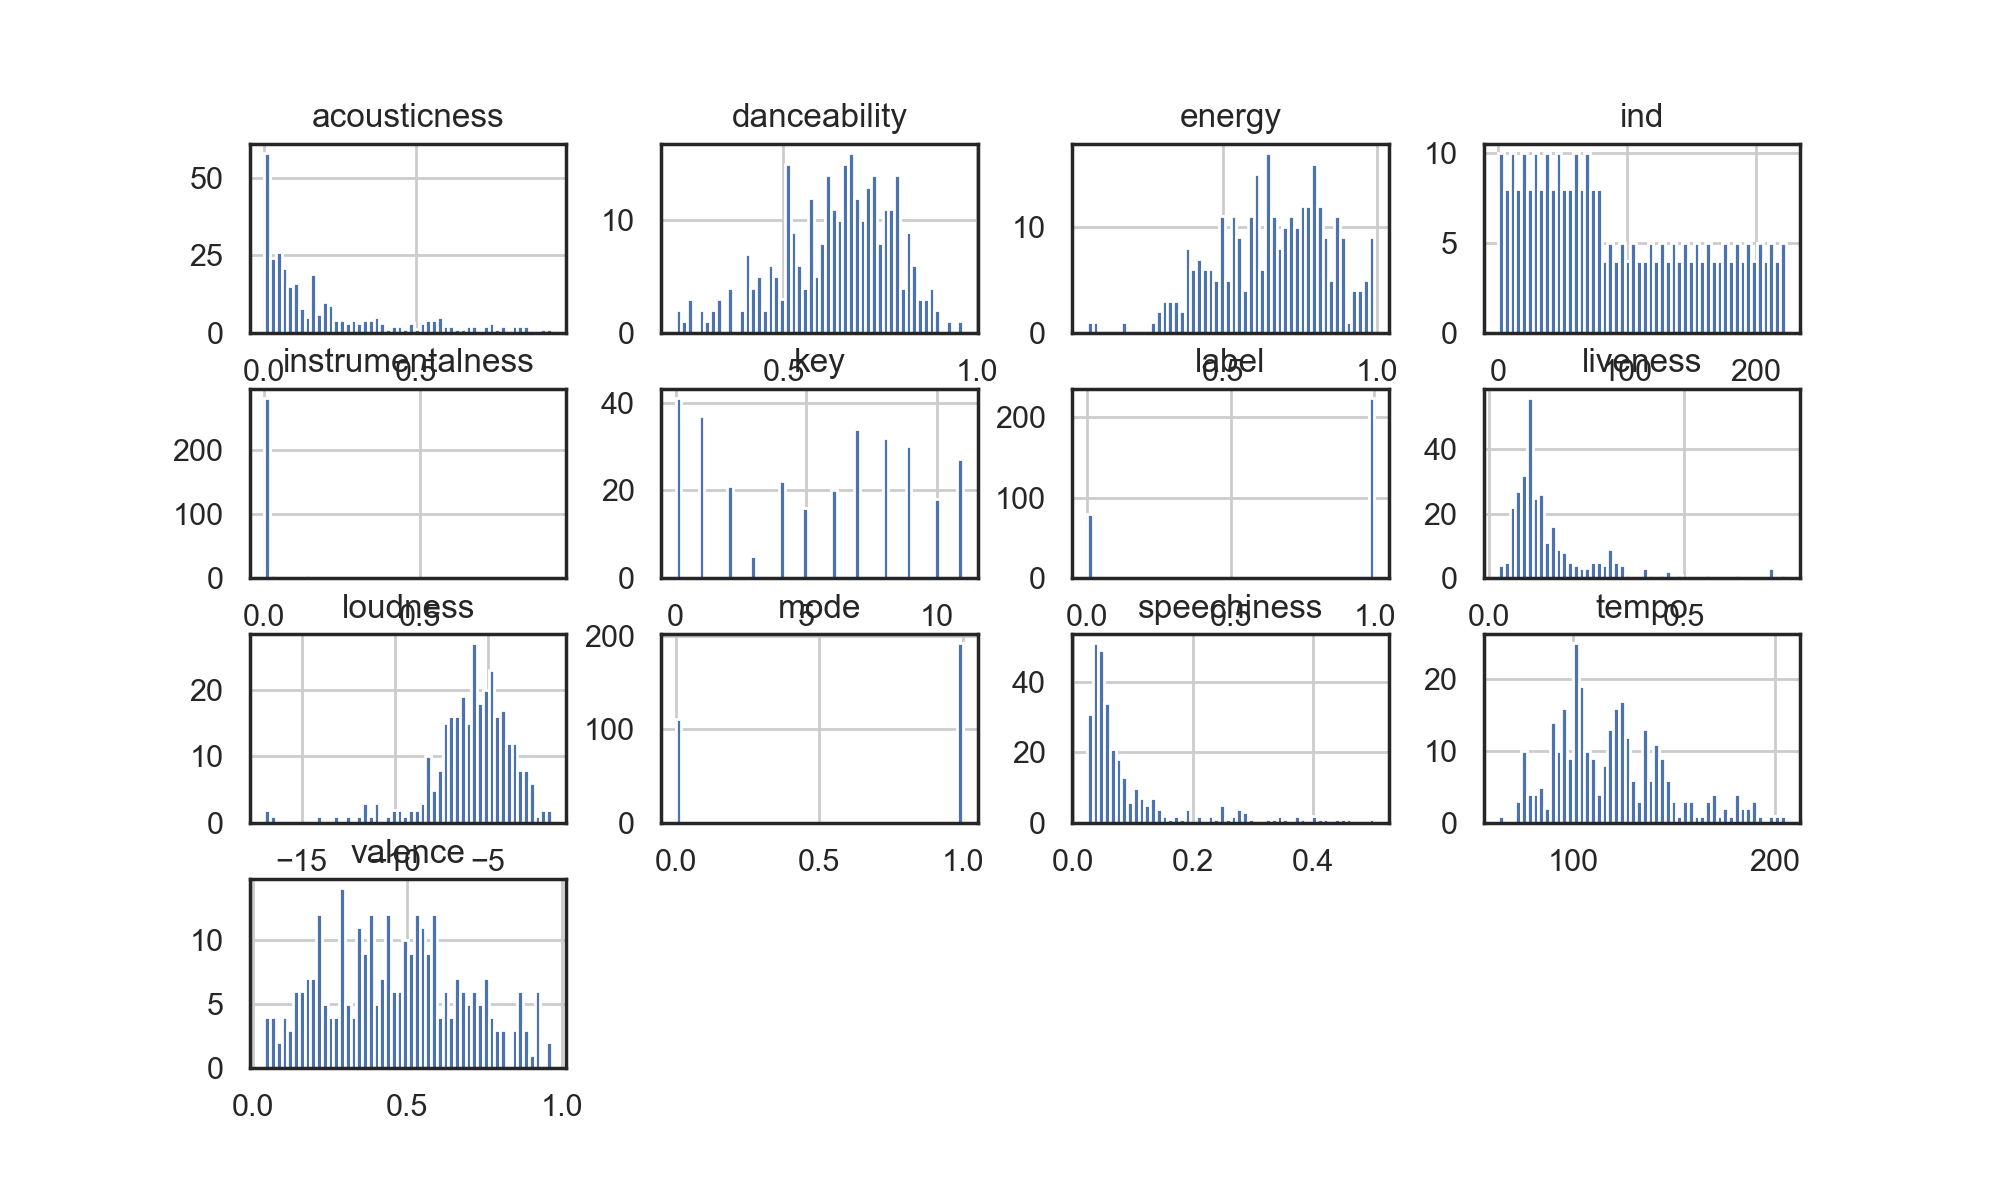

In [51]:
songs_df.hist(bins=50, figsize=(10,6))
plt.show()
#tail heavy - acousticness, liveness, speechiness, tempo

Let's try to understand the meaning of these features from Spotify API's Documentation. 

- __acousticness (float)__ ~ A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.


- __danceability (float)__ ~ Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.


- __energy (float)__ ~ Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.


- __instrumentalness (float)__ ~ Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.


- __key (int)__ ~ The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.


- __liveness (float)__ ~ Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.


- __loudness (float)__ ~ The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.


- __mode (int)__ ~ Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.


- __speechiness (float)__ ~ Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.


- __tempo (float)__ ~ The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.


- __valence(float)__ ~ A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

# Creating Train and Test Sets

We can see that in our tiny dataset, there is a huge imbalance with liked instances almost 3 times as many as the disliked instanced. To solve this problem, we will experiment with some data balancing techniques. 

In [52]:
X = songs_df.drop('label', axis=1)
y = songs_df['label']

__StratifiedKFold__ function maintains the representation of our classes in both the training set and the testing set. StratifiedKFold also makes sure that our test sets do not overlap by only shuffling our data once. 

In [53]:
# Seperating Test Set and Train Set

sss = StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [54]:
song_names_train = list(X_train["song_name"])
X_train = X_train.drop(columns=['ind','song_name','song_id'])

In [55]:
X_test = X_test.drop(columns=['ind','song_name','song_id'])

In [56]:
# Turn into an array for the Machine Learning Algorithms
X_train_ = X_train.values
X_test_ = X_test.values
y_train_ = y_train.values
y_test_ = y_test.values

In [57]:
corr_matrix = X_train.corr()
corr_matrix

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
acousticness,1.000000,-0.044784,-0.625656,0.083108,0.005551,-0.067533,-0.425854,0.129216,-0.005128,-0.165242,-0.058903
danceability,-0.044784,1.000000,-0.059018,-0.262384,-0.101786,-0.058427,0.117075,0.039080,0.017982,-0.208269,0.499298
energy,-0.625656,-0.059018,1.000000,-0.196004,0.030884,0.195338,0.742144,-0.086025,0.077362,0.165656,0.187927
instrumentalness,0.083108,-0.262384,-0.196004,1.000000,-0.013417,0.073842,-0.424882,-0.005456,-0.098174,0.040811,-0.258897
key,0.005551,-0.101786,0.030884,-0.013417,1.000000,0.026057,-0.063148,-0.118020,0.057220,-0.033425,-0.104675
liveness,-0.067533,-0.058427,0.195338,0.073842,0.026057,1.000000,0.058620,-0.005251,0.174597,0.031522,-0.058800
loudness,-0.425854,0.117075,0.742144,-0.424882,-0.063148,0.058620,1.000000,-0.094662,-0.081901,0.086651,0.242030
mode,0.129216,0.039080,-0.086025,-0.005456,-0.118020,-0.005251,-0.094662,1.000000,-0.112466,-0.059363,-0.025435
speechiness,-0.005128,0.017982,0.077362,-0.098174,0.057220,0.174597,-0.081901,-0.112466,1.000000,0.148808,0.149927
tempo,-0.165242,-0.208269,0.165656,0.040811,-0.033425,0.031522,0.086651,-0.059363,0.148808,1.000000,-0.105738


<IPython.core.display.Javascript object>


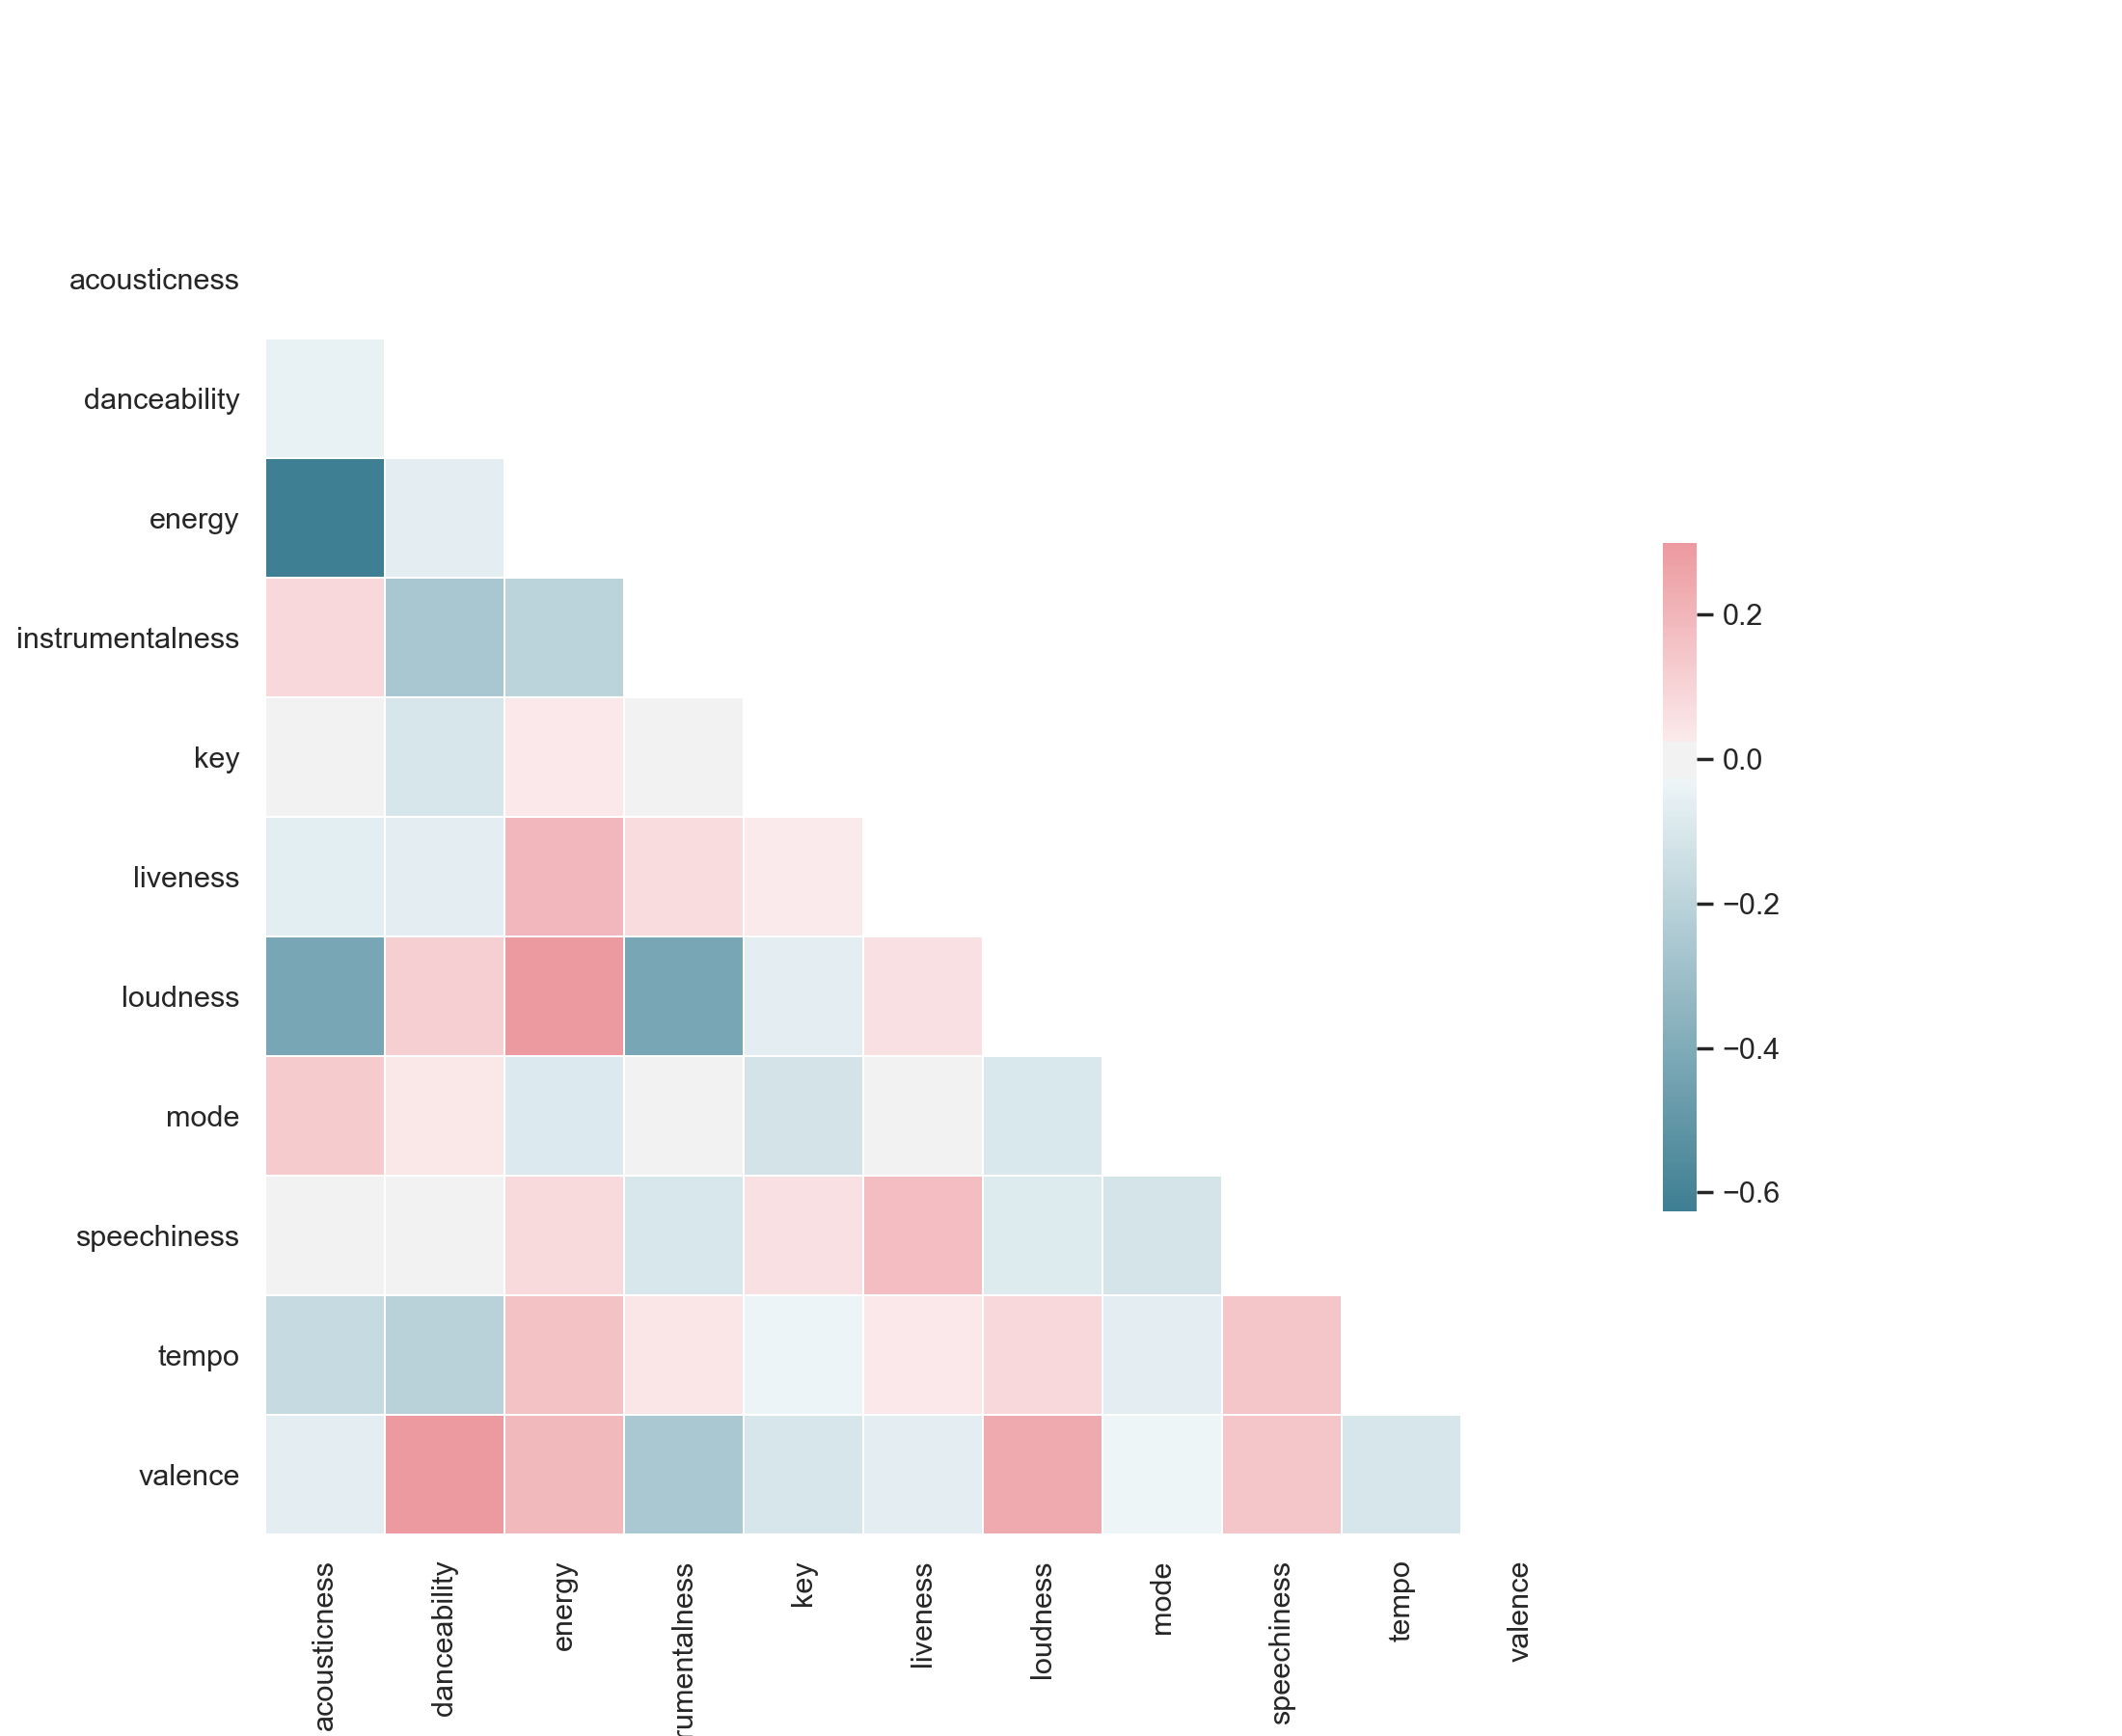

In [58]:
"""Visualizing Correlation Matrix"""

sns.set(style="white")


# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [15]:
"""Function to remove the correlated covariates - address multicollinearity.
Uses VARIANCE INFLATION FACTOR (VIF) to identify the highly correlated features
and get rid of the appropriate ones"""

from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [59]:
X_train_VIF = calculate_vif_(X_train,5)

dropping 'danceability' at index: 1
dropping 'energy' at index: 1
dropping 'loudness' at index: 4
dropping 'tempo' at index: 6
Remaining variables:
Index(['acousticness', 'instrumentalness', 'key', 'liveness', 'mode',
       'speechiness', 'valence'],
      dtype='object')


# Visualizng our training data

In [60]:
cluster_features = ['acousticness', 'danceability', 'instrumentalness', 'energy', 'speechiness']
df_cluster = X_train[cluster_features]
X_visualization = np.array(df_cluster)
scaler = StandardScaler()
scaler.fit(X_visualization)
X_visualization = scaler.transform(X_visualization)

Before we cluster our data, we need to settle on a number of clusters we wish to have our data separated into. For this purpose, we're using the Elbow method. 

The __Elbow Method__, we perform clustering for a range of set cluster numbers e.g. k=1, k=2,... For each k, we will take each point and measure its squared distance to their cluster centroid, and sum them up. This is called the sum of squared distances (SSD). SSD measures how close each points are to the cluster centroid. Therefore, the smaller the SSD, the closer the points in the same cluster are.

<IPython.core.display.Javascript object>


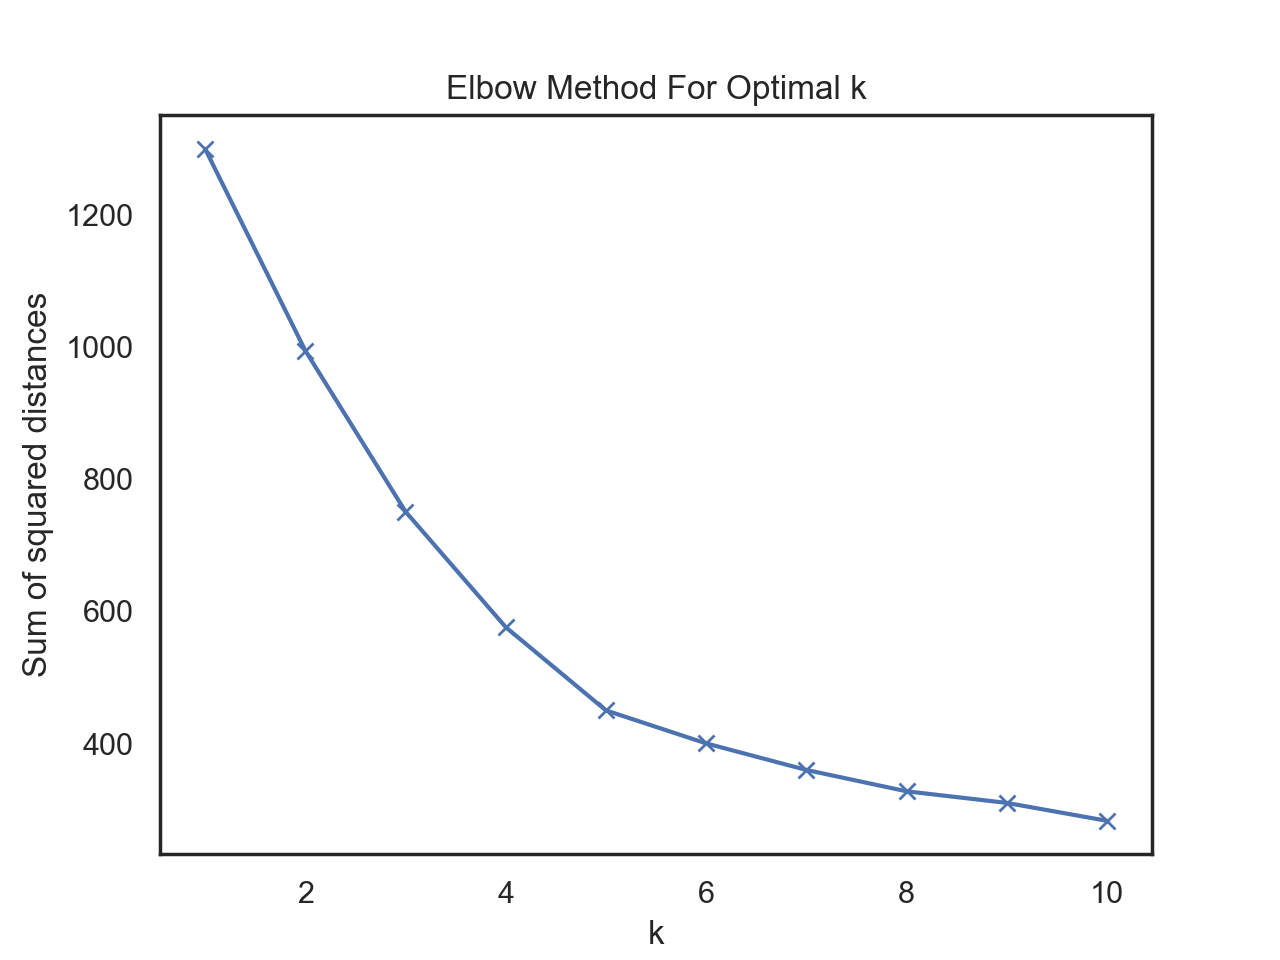

In [61]:
#Elbow method to determine k for k-means clustering

ss_dist = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=123)
    km = km.fit(X_visualization)
    ss_dist.append(km.inertia_)
plt.figure()
plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the plot above we see that the SSD is decreasing, which makes total sense. As you increase the number of clusters to the number of data points, you have SSD equal to 0. This is because each data point becomes a cluster centroid. Clearly this will be a case where you have severely overfitted your model to the training data. One way to choose k while avoiding overfitting is to look for the inflection point after which the gradient decreases in magnitude. In the graph above, that happens at k = 5. Therefore, we will choose number of clusters = 5.

<IPython.core.display.Javascript object>


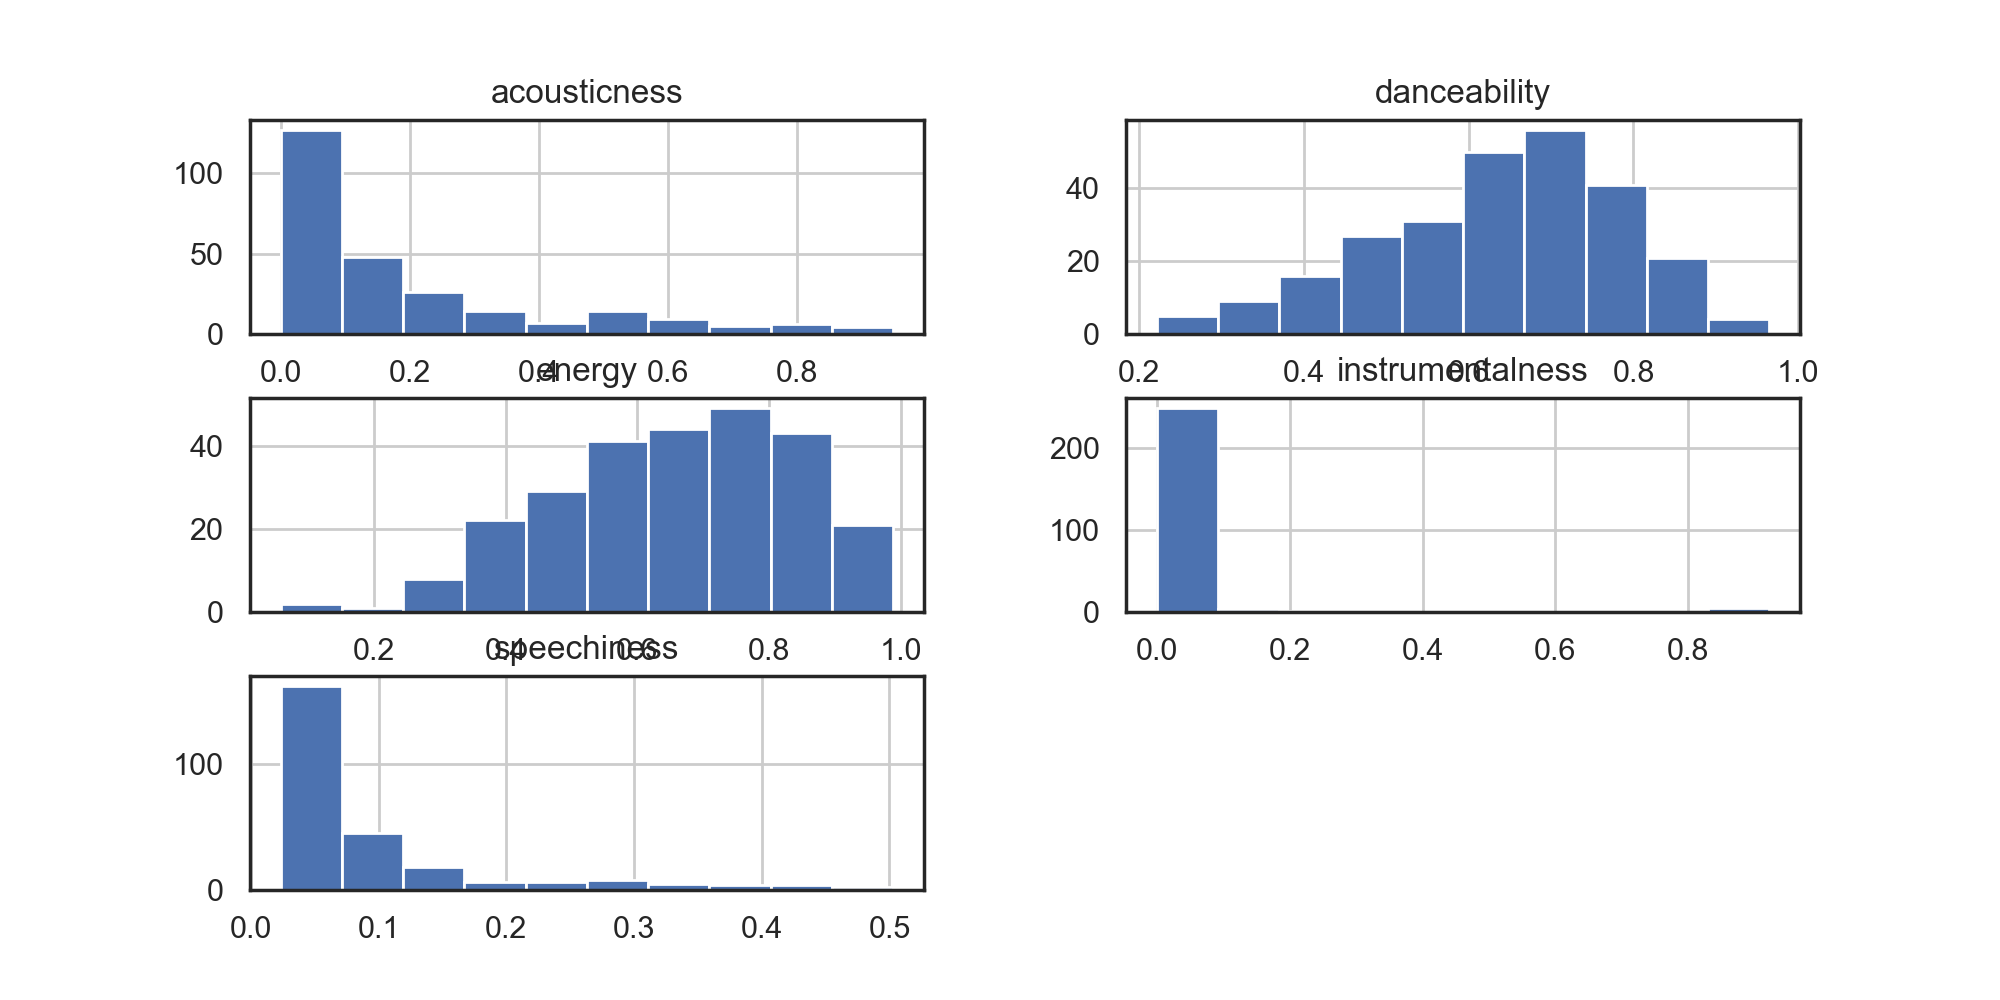

In [62]:
df_cluster.hist(figsize=(10,5))
plt.show()

In [64]:
num_clusters = 5 #elbow method shows an inflection point at 5
kmeanModel = KMeans(n_clusters=num_clusters, max_iter=10000, init='k-means++', random_state=123).fit(X_visualization)

### PCA

In [65]:
pca = PCA(n_components=3, random_state=123)
pca_results = pca.fit_transform(X_visualization)

In [66]:
print(pca.explained_variance_ratio_.sum())
pca.explained_variance_ratio_.cumsum()

0.7858408582282532


array([0.3401693 , 0.58743565, 0.78584086])

In [67]:
df_pca_vis = pd.DataFrame({'Component': ['1','2','3'],'Indiv':pca.explained_variance_ratio_})
df_pca_vis['cum_sum'] = df_pca_vis['Indiv'].cumsum()
df_pca_vis

,Component,Indiv,cum_sum
0,1,0.340169,0.340169
1,2,0.247266,0.587436
2,3,0.198405,0.785841


<IPython.core.display.Javascript object>


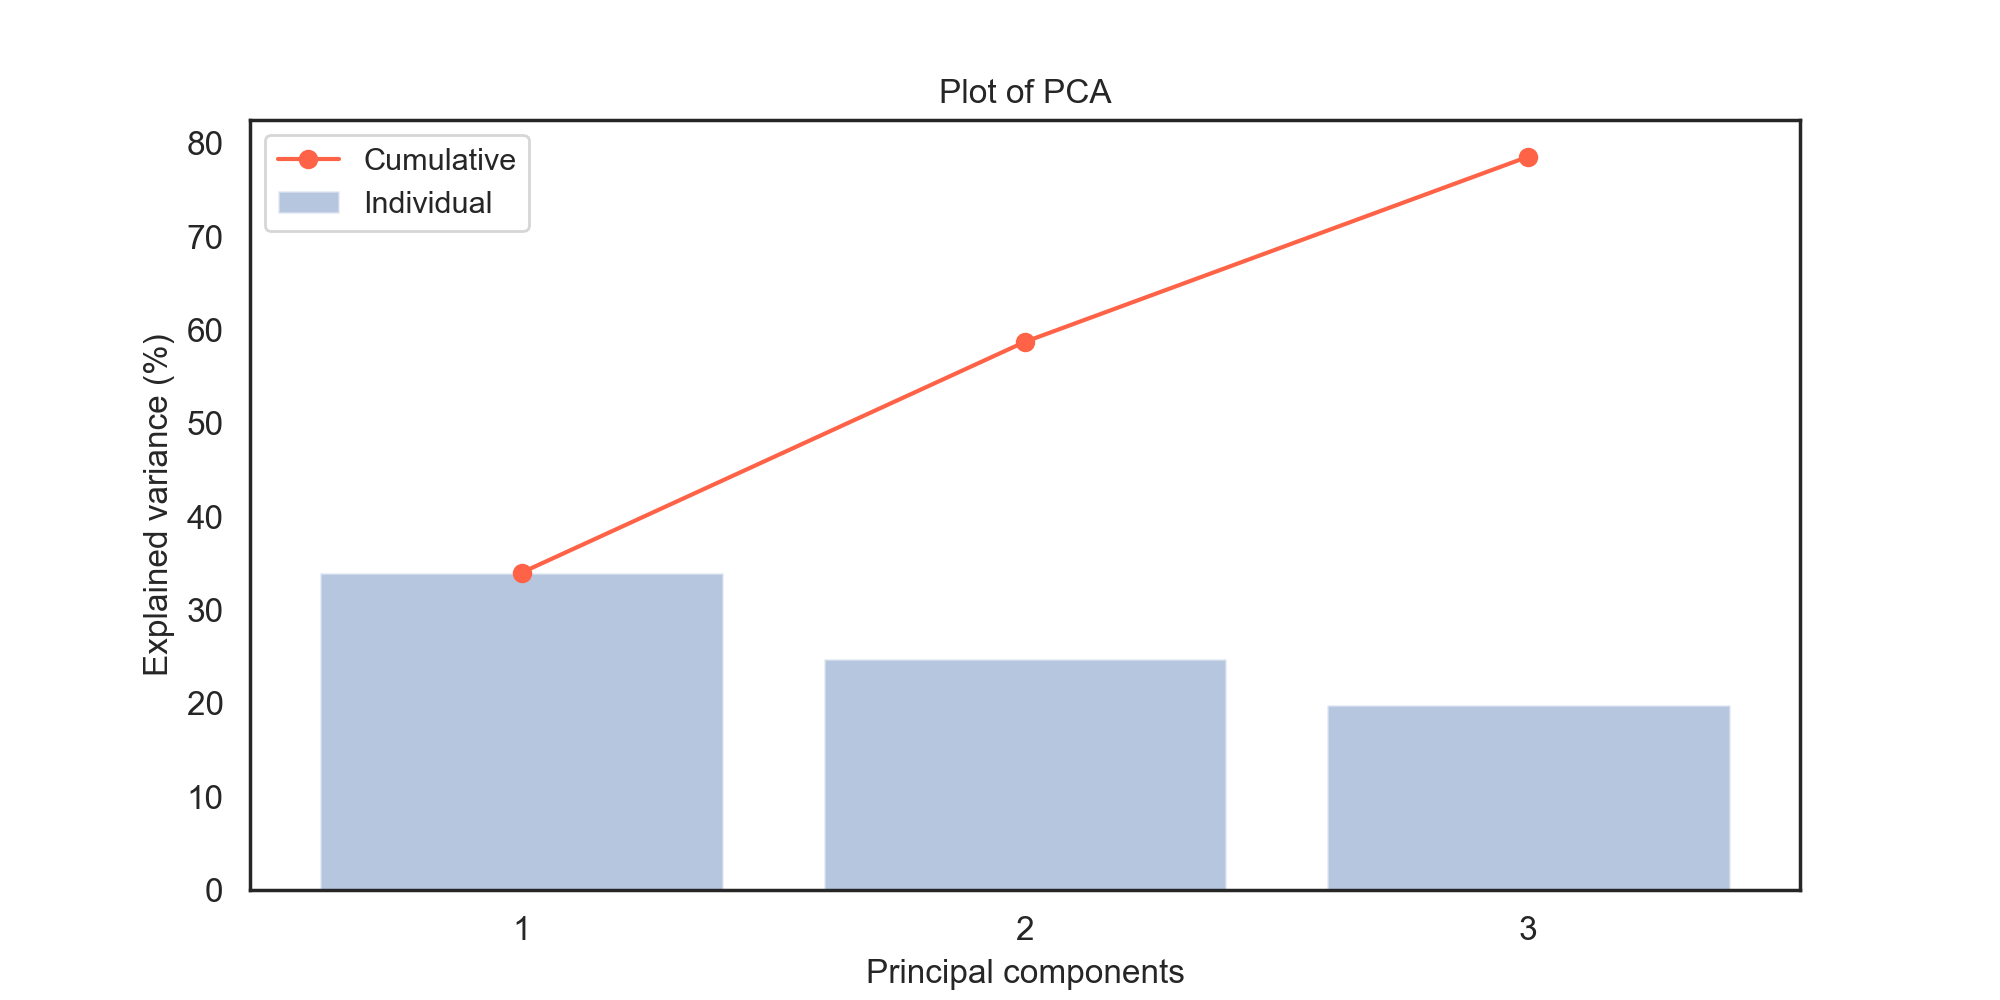

In [68]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, 
        label='Individual', axes=ax, alpha=0.4)
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='tomato', axes=ax, marker='o')

ax.set_xticks(range(0,3))
ax.set_xticklabels(range(1,4), fontsize=12)
ax.set_yticklabels(range(0,90,10), fontsize=12)

plt.title('Plot of PCA', fontsize=12)
plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
plt.legend()
plt.show()

In [25]:
df_pca = pd.DataFrame(pca_results)
df_pca.columns = ['PC1', 'PC2','PC3']
df_pca['label'] = kmeanModel.labels_
df_pca.head()

,PC1,PC2,PC3,label
0,-0.609793,-0.986435,0.605367,3
1,0.655796,-1.615916,1.555999,0
2,2.797130,-1.853778,-0.566186,1
3,-0.374531,-0.055472,-0.158674,3
4,-1.254326,-0.737540,-0.212609,3


<IPython.core.display.Javascript object>


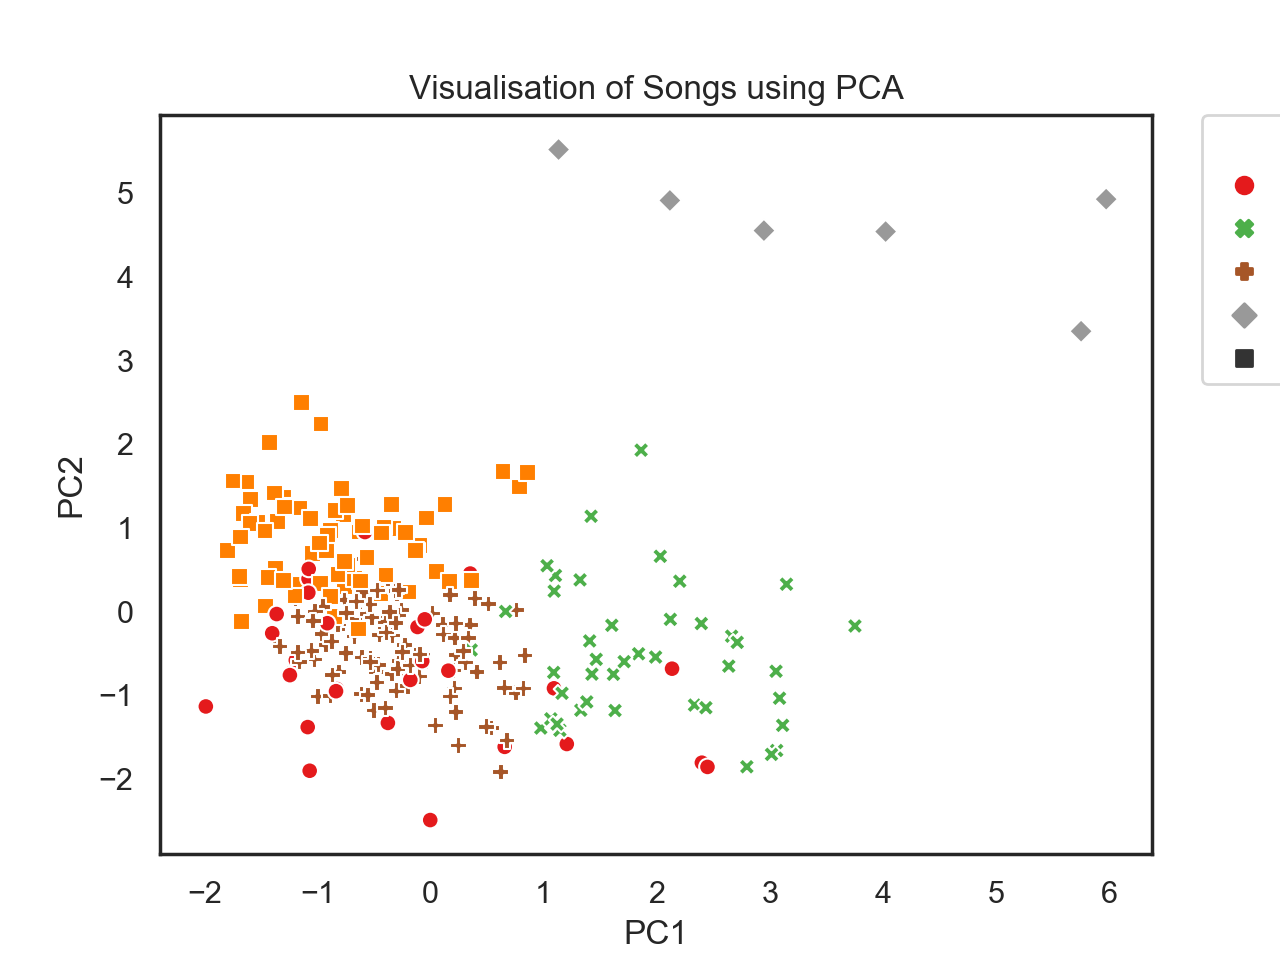

In [69]:
plt.figure()
sns.set_style('white')
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs using PCA')
plt.show()

<IPython.core.display.Javascript object>


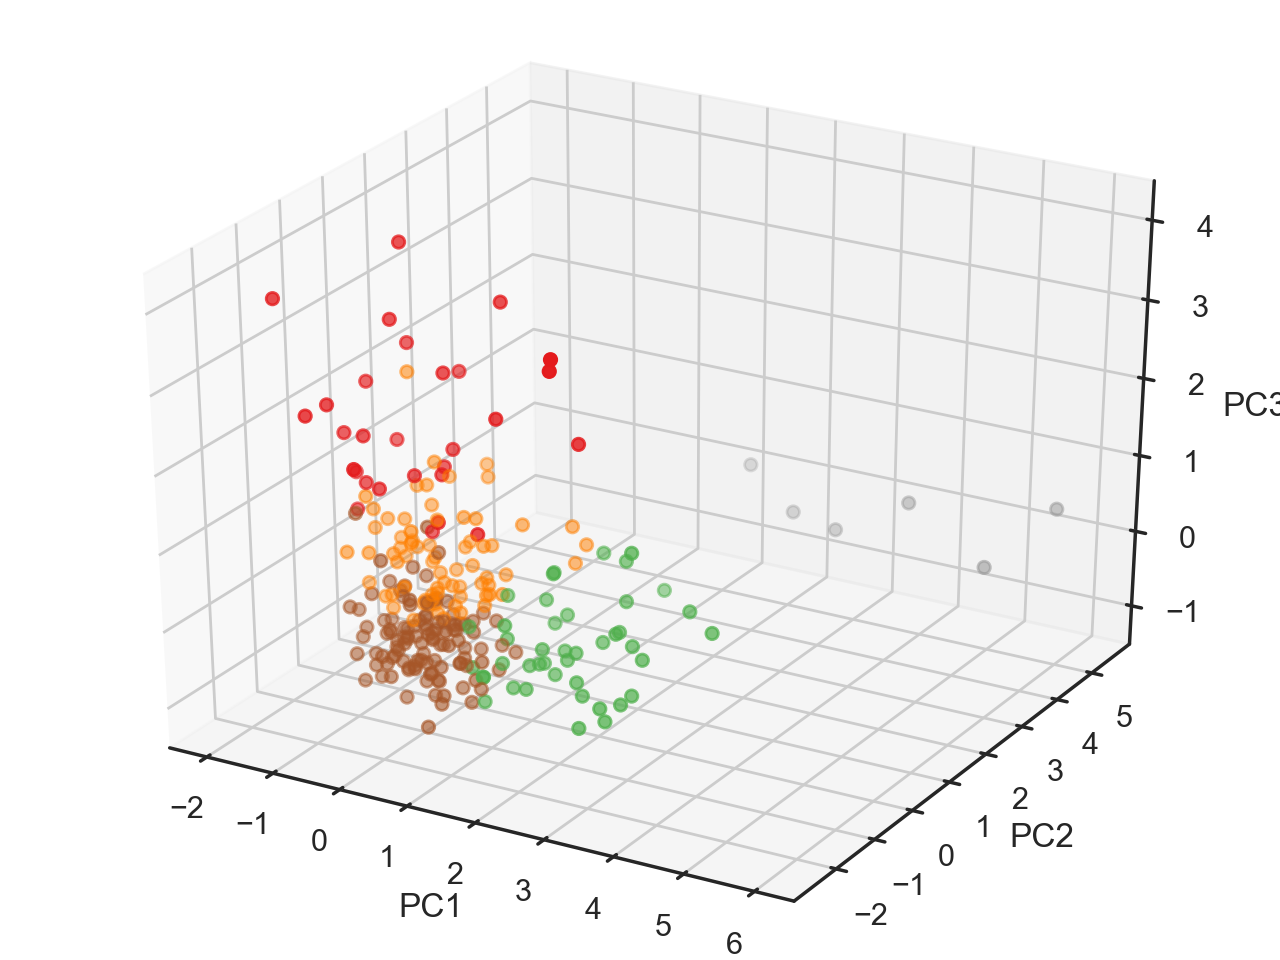

In [70]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],
           c=df_pca['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### t-SNE 

In [71]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=123, learning_rate=190)
tsne_results = tsne.fit_transform(X_visualization)

In [72]:
df_tsne = pd.DataFrame(tsne_results)
df_tsne.columns = ['D1', 'D2']
df_tsne['label'] = kmeanModel.labels_
df_tsne.head()

,D1,D2,label
0,-0.099611,6.903080,3
1,-1.201608,10.481782,0
2,-5.450896,6.221231,1
3,-4.425562,1.146659,3
4,-2.632696,3.683017,3


<IPython.core.display.Javascript object>


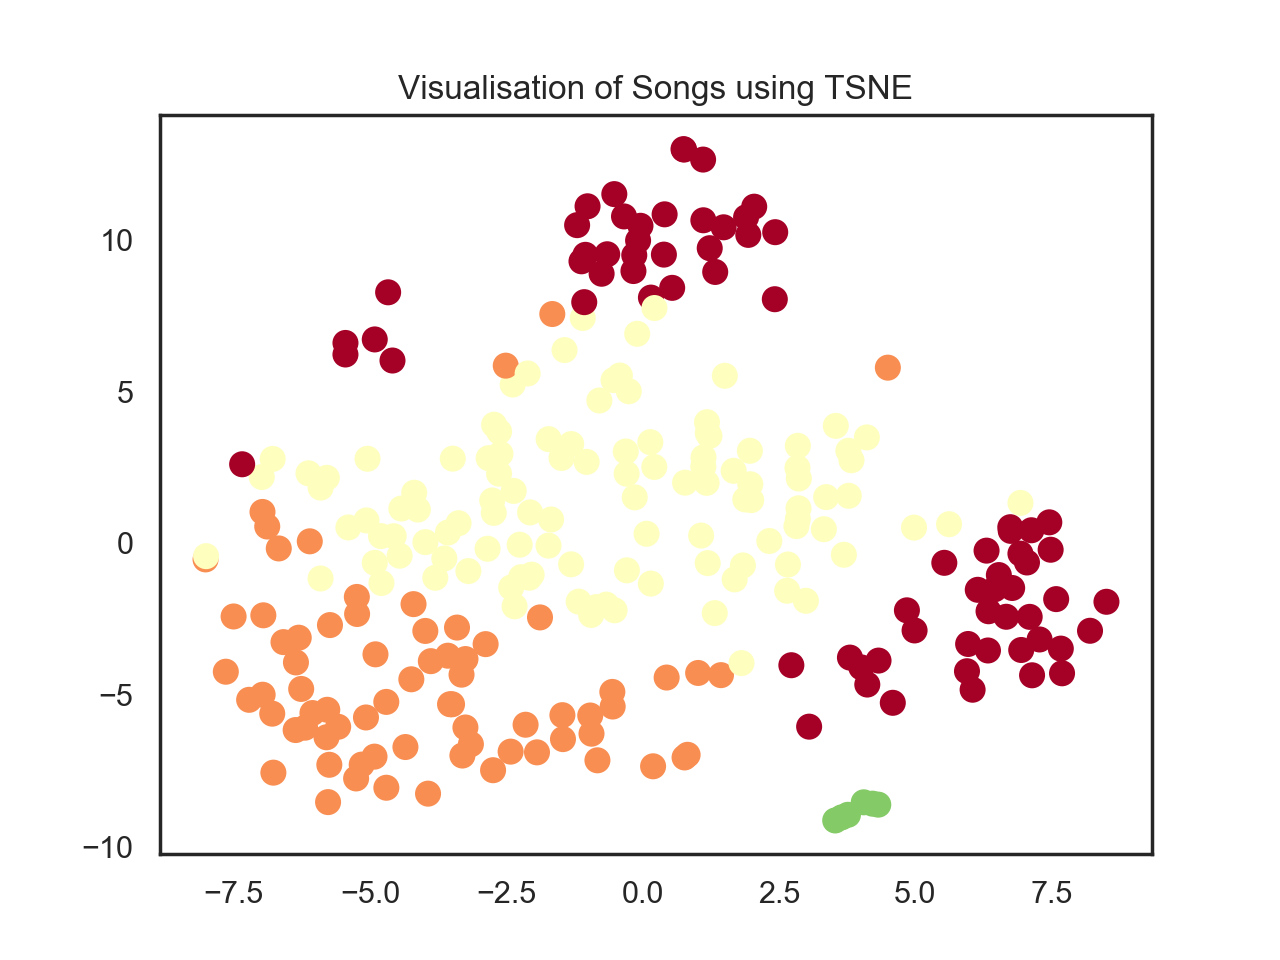

In [73]:
# visualizing the clusters by reducing the dimension of the data through t-SNE
# added the hover effect over the graph so you can see the name of the song for each data point in the graph

c = np.random.randint(1,5,size=len(song_names_train))

norm = plt.Normalize(1,5)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(df_tsne['D1'], df_tsne['D2'], c=df_tsne['label'], s=70, cmap=cmap, norm=norm)
plt.title('Visualisation of Songs using TSNE')
annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)


def hover(event):
    def update_annot(ind):

        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        text = "{}".format(" ".join([song_names_train[n] for n in ind["ind"]]))
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(0.4)


    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
        

fig.canvas.mpl_connect("motion_notify_event", hover)
#plt.gcf().set_size_inches((12, 8)) 
plt.show();

<IPython.core.display.Javascript object>


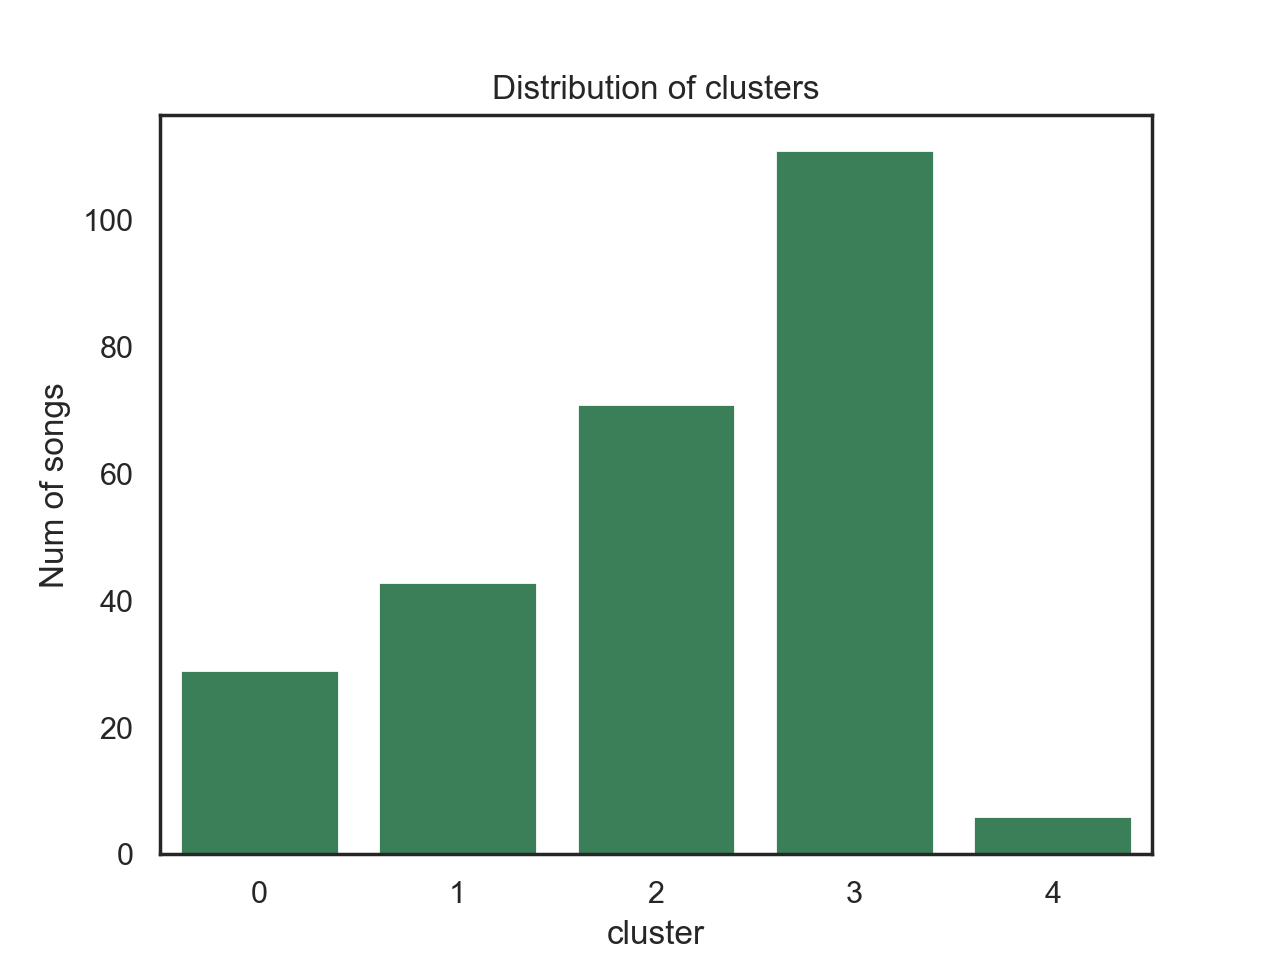

In [74]:
X_train.loc[:,'cluster'] = kmeanModel.labels_
df_cluster_size = X_train.groupby('cluster').size().reset_index(name='Num of songs')
plt.figure()
sns.barplot(data=df_cluster_size, x='cluster', y='Num of songs', color='seagreen')
plt.title('Distribution of clusters')
plt.show();

<IPython.core.display.Javascript object>


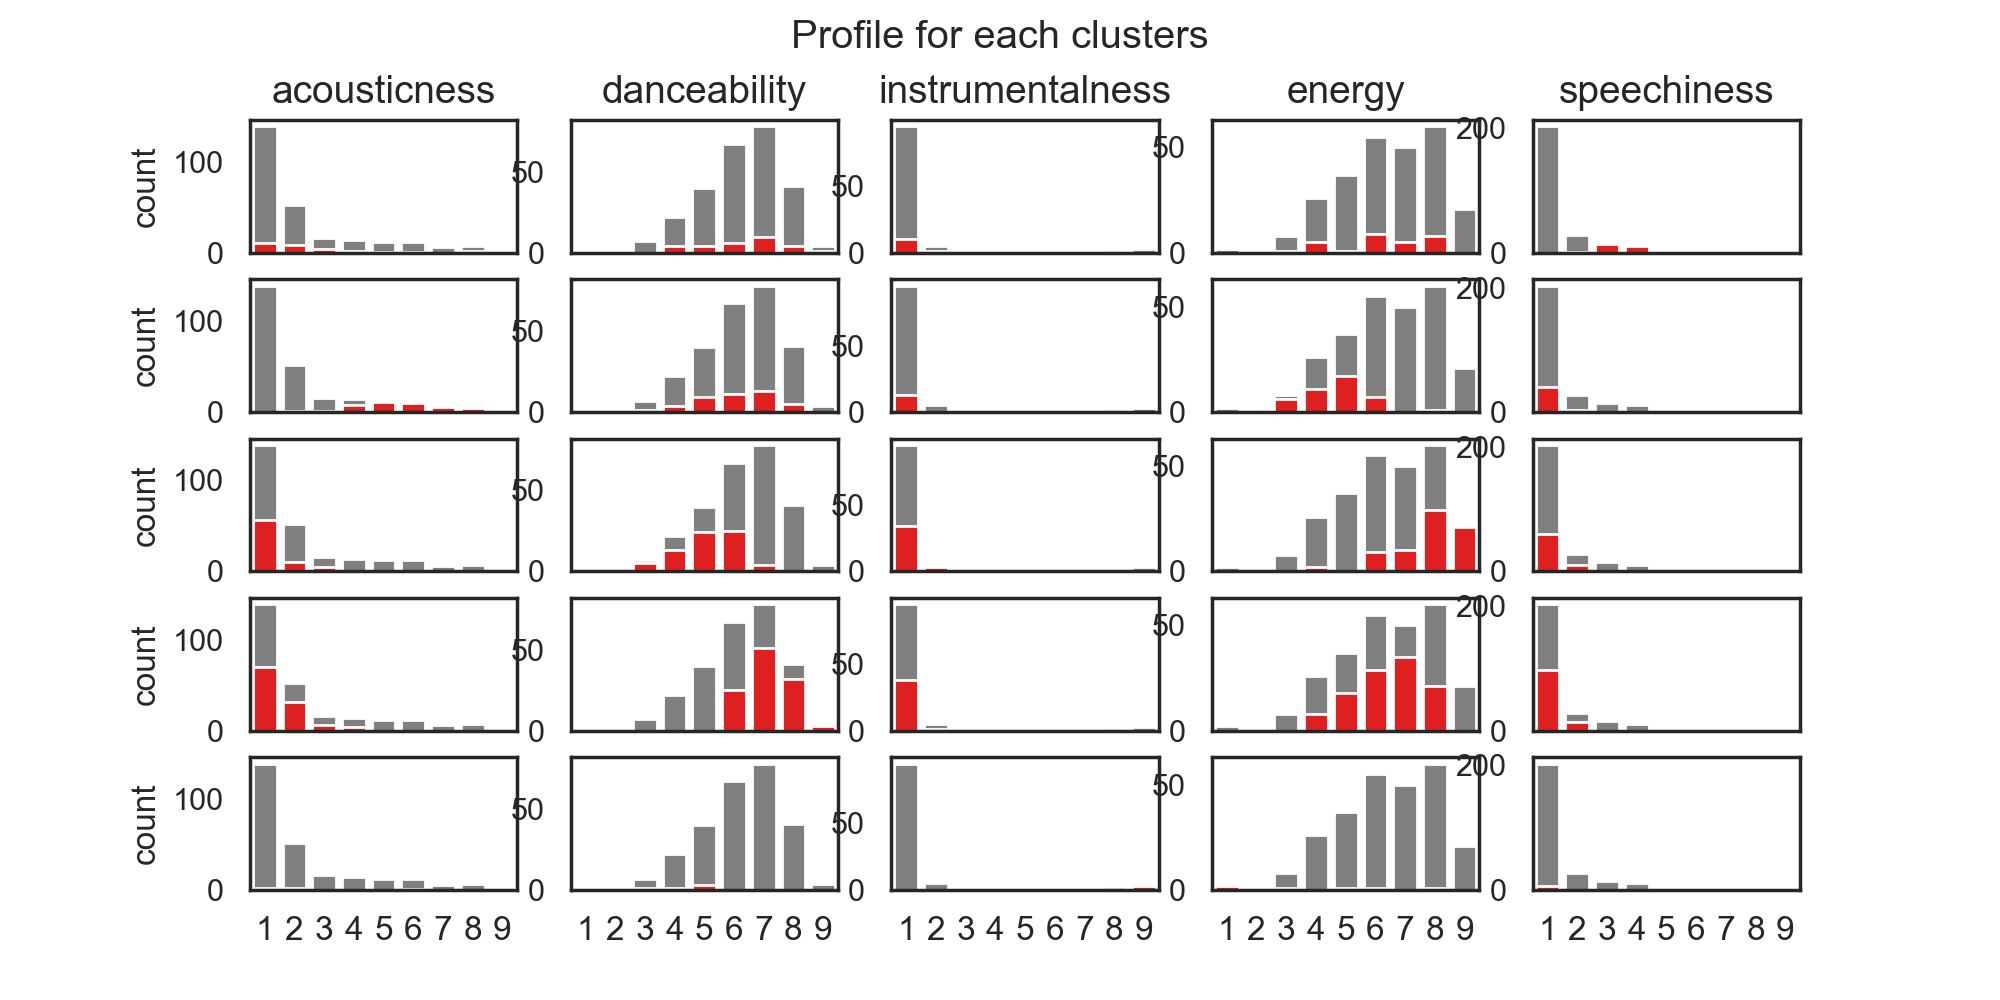

In [75]:
# set binning intervals of 0.1
bins = np.linspace(0,1,10)

# create subplots
num_features = len(cluster_features)
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(10, 5), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(X_train['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = X_train[X_train['cluster'] == cluster]
    col = 0
    
    for feature in cluster_features:
#         create binned count for all recent df and clustered df
        rec_grp = X_train.groupby(pd.cut(X_train[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel('count', fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1
    
f.suptitle('Profile for each clusters')
    
plt.show()

# Predictive Analysis

In [76]:
'''# Turn into an array for the Machine Learning Algorithms
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values'''

'# Turn into an array for the Machine Learning Algorithms\nX_train = X_train.values\nX_test = X_test.values\ny_train = y_train.values\ny_test = y_test.values'

In [77]:
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train))
print(test_counts_label/ len(y_test))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.26153846 0.73846154]
[0.25581395 0.74418605]


In [78]:
# Feature Scaling

from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler

preprocess_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

X_train_ = preprocess_pipeline.fit_transform(X_train_)

train_mean = preprocess_pipeline.steps[0][1].mean_
train_std = preprocess_pipeline.steps[0][1].var_ ** (1/2)

X_test = ((X_test - train_mean) / train_std)

In [79]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))

Length of X (train): 260 | Length of y (train): 260
Length of X (test): 43 | Length of y (test): 43


In [80]:
# List to append the score and then find the average
accuracy = []
precision = []
recall = []
f1 = []
auc = []

In [81]:
# Classifiers

# Random Forest
rand_for_sm = RandomForestClassifier()
rand_for_params = {"max_depth": [4, 3, None],
              "max_features": [2, 3, 11],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
rand_for = RandomizedSearchCV(rand_for_sm, rand_for_params, n_iter=4)


# Logistic Regression
log_reg_sm = LogisticRegression()
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg = RandomizedSearchCV(log_reg_sm, log_reg_params, n_iter=4)

# Gradient Boosting 

gr_boo_sm = GradientBoostingClassifier()
gr_boo_params = {"max_depth": [4, 3, None],
              "max_features": [2, 3, 11],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              #"bootstrap": [True, False],
              "criterion": ["friedman_mse", "mse", "mae"]}
gr_boo = RandomizedSearchCV(gr_boo_sm, gr_boo_params, n_iter=4)

### Handling imbalance data with SMOTE

One error people often make is to oversample data and then perform cross-validation. This is wrong because by doing so you're influencing your validation set that you'll be creating during the cross validation. In the function below, we apply the oversampling step inside the cross validation step. By doing so, we preserve a validation step from the original data and then synthesise data from the remaining data to be used in training. 

In [82]:
def cv_smote(classifier):
    # Implementing SMOTE Technique 
    # Cross Validating the right way

    for train, test in sss.split(X_train_, y_train_):
        # SMOTE happens during Cross Validation not before
        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), classifier)
        model = pipeline.fit(X_train_[train], y_train_[train])
        best_est = classifier.best_estimator_
        prediction = best_est.predict(X_train_[test])

        accuracy.append(pipeline.score(X_train_[test], y_train_[test]))
        precision.append(precision_score(y_train_[test], prediction))
        recall.append(recall_score(y_train_[test], prediction))
        f1.append(f1_score(y_train_[test], prediction))
        auc.append(roc_auc_score(y_train_[test], prediction))

    print('---' * 20)
    print()
    print("accuracy: {}".format(round(np.mean(accuracy),3)))
    print("precision: {}".format(round(np.mean(precision),3)))
    print("recall: {}".format(round(np.mean(recall),3)))
    print("f1: {}".format(round(np.mean(f1),3)))
    print()
    print('---' * 20)
    
    return best_est

In [83]:
classifiers_list = []

print("Results for RandomForestClassifier")
rand_for_est = cv_smote(rand_for)
classifiers_list.append(("Random Forest Classifier",rand_for_est))

print("Results for LogisticRegression")
log_reg_est = cv_smote(log_reg)
classifiers_list.append(("Logistic Regression Classifier",log_reg_est))

print("Results for GradientBoostingClassifier")
gr_boo_est = cv_smote(gr_boo)
classifiers_list.append(("Gradient Bossting Classifier",gr_boo_est))


Results for RandomForestClassifier
------------------------------------------------------------

accuracy: 0.689
precision: 0.804
recall: 0.771
f1: 0.785

------------------------------------------------------------
Results for LogisticRegression
------------------------------------------------------------

accuracy: 0.628
precision: 0.796
recall: 0.667
f1: 0.72

------------------------------------------------------------
Results for GradientBoostingClassifier
------------------------------------------------------------

accuracy: 0.658
precision: 0.8
recall: 0.717
f1: 0.75

------------------------------------------------------------


In [84]:
def print_report(classifier):
    labels = ['Disliked', 'Liked']
    smote_prediction = classifier.predict(X_test)
    print("Result for: {}".format(str(classifier)))
    print(classification_report(y_test, smote_prediction, target_names=labels))

for classifier in classifiers_list:
    print_report(classifier[1])

Result for: RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
              precision    recall  f1-score   support

    Disliked       0.78      0.64      0.70        11
       Liked       0.88      0.94      0.91        32

    accuracy                           0.86        43
   macro avg       0.83      0.79      0.80        43
weighted avg       0.86      0.86      0.86        43

Result for: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
               

### Baseline Model

In [85]:
# Baseline Prediction
baseline = np.random.randint(0,2,len(y_test))

unique, counts = np.unique(baseline == y_test, return_counts=True)
print("Prediction with a random model (baseline) ~ {}: {}, {}: {}".format(unique[0],counts[0],unique[1],counts[1]))
print("Baseline F1 score: ", round(f1_score(y_test, baseline),2))

Prediction with a random model (baseline) ~ False: 25, True: 18
Baseline F1 score:  0.49


### Model Comparison

In [86]:
y_ens = []
for classifier in classifiers_list:
    y_pred = classifier[1].predict(X_test)
    y_ens.append(y_pred)
    
    unique, counts = np.unique(y_pred == y_test, return_counts=True)
    print(classifier[0], " : ",dict(zip(unique, counts)))
    print("F1 score: ", round(f1_score(y_test, y_pred),2))
    print()

Random Forest Classifier  :  {False: 6, True: 37}
F1 score:  0.91

Logistic Regression Classifier  :  {False: 24, True: 19}
F1 score:  0.54

Gradient Bossting Classifier  :  {False: 9, True: 34}
F1 score:  0.87



<IPython.core.display.Javascript object>


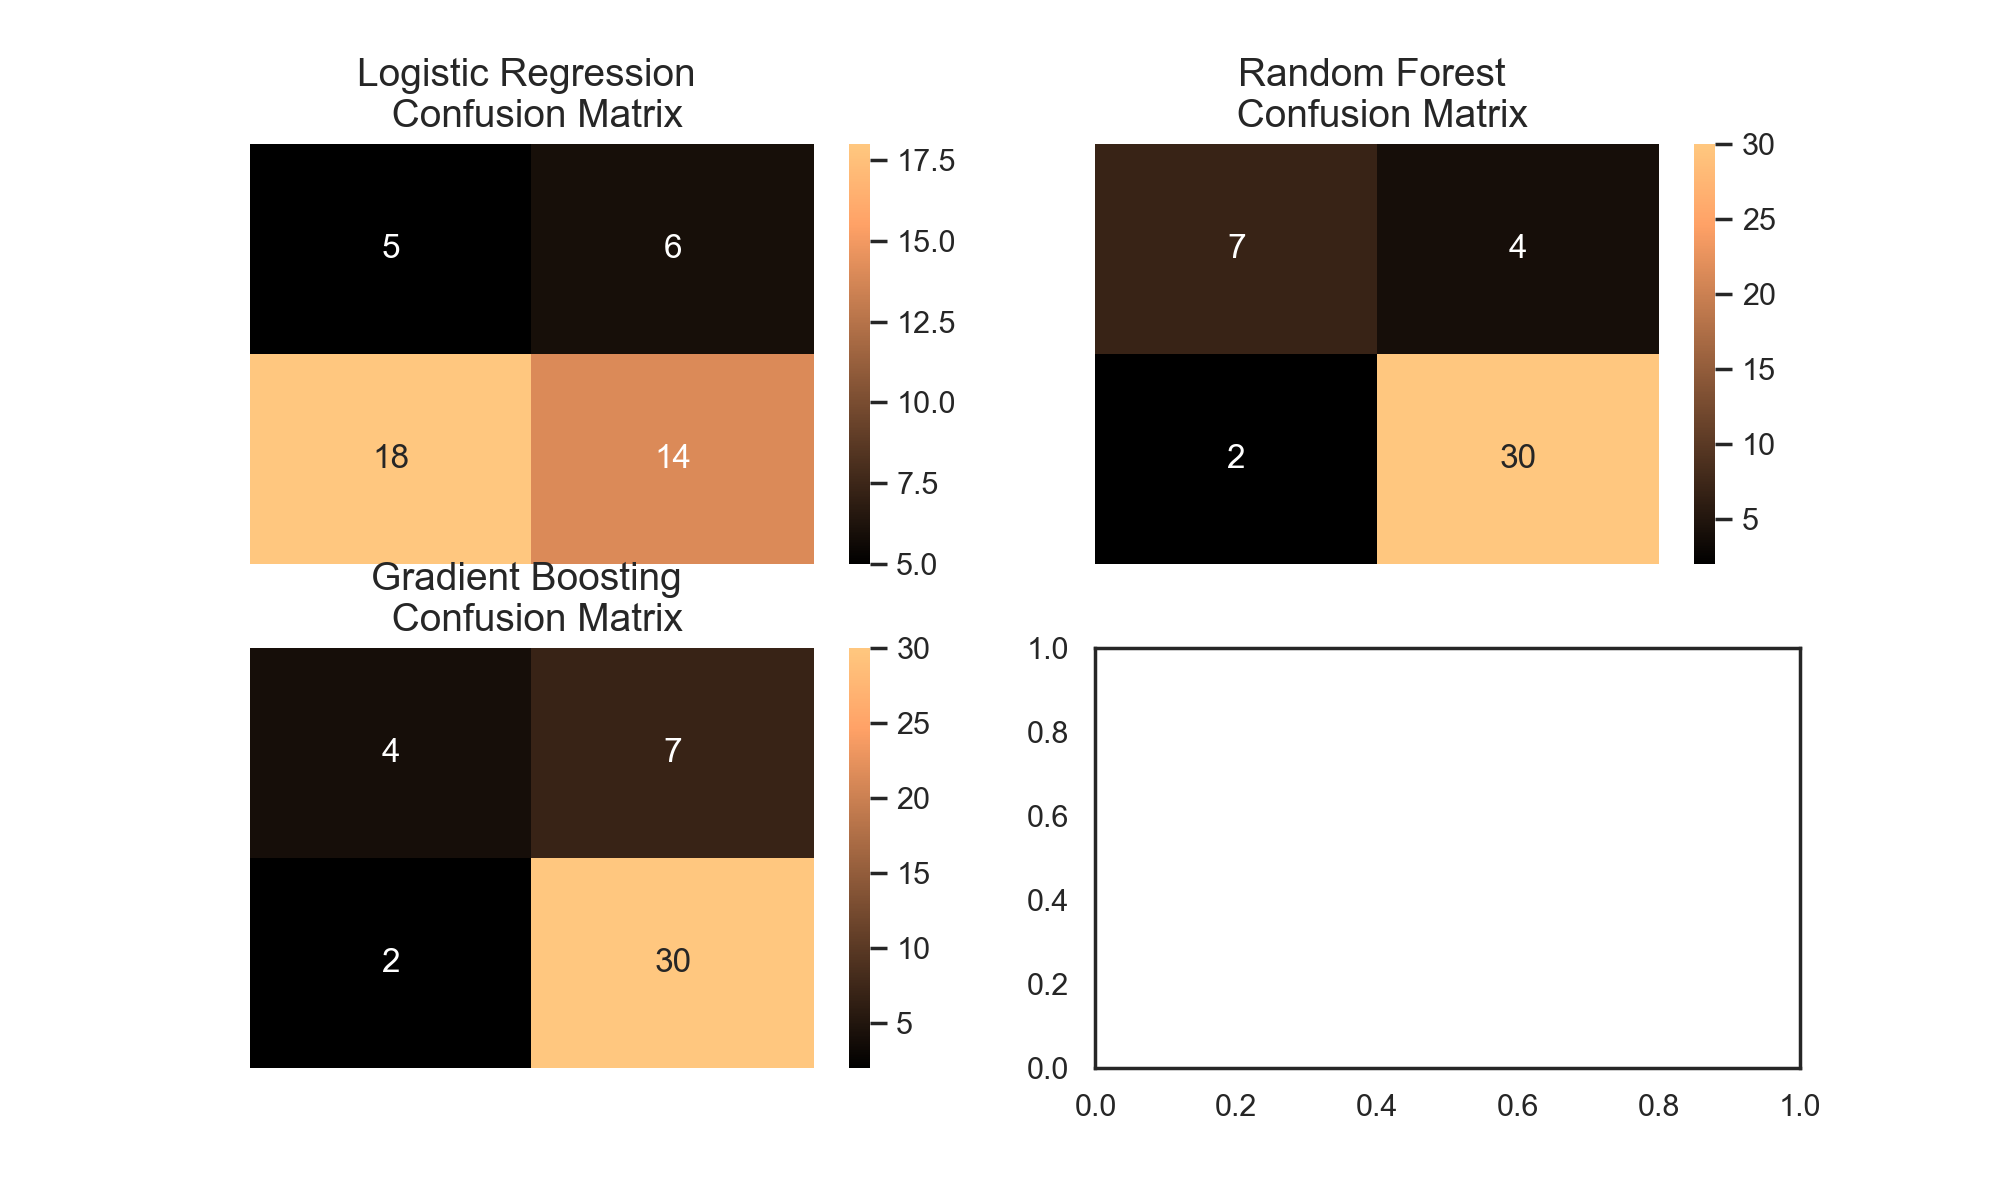

In [87]:
from sklearn.metrics import confusion_matrix

y_pred_log_reg = y_ens[1]

y_pred_tree = y_ens[0]
y_pred_gb = y_ens[2]


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
tree_cf = confusion_matrix(y_test, y_pred_tree)
gb_cf = confusion_matrix(y_test, y_pred_gb)

fig, ax = plt.subplots(2, 2,figsize=(10,6))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("Random Forest \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(gb_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Gradient Boosting \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

As we can see, our models don't perform very well for disliked songs - my understanding is that the dataset is not rich enough. Also, I randomly added a few songs from the genres I disliked, so perhaps the data could be made much better by carefully adding more instances. 